/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


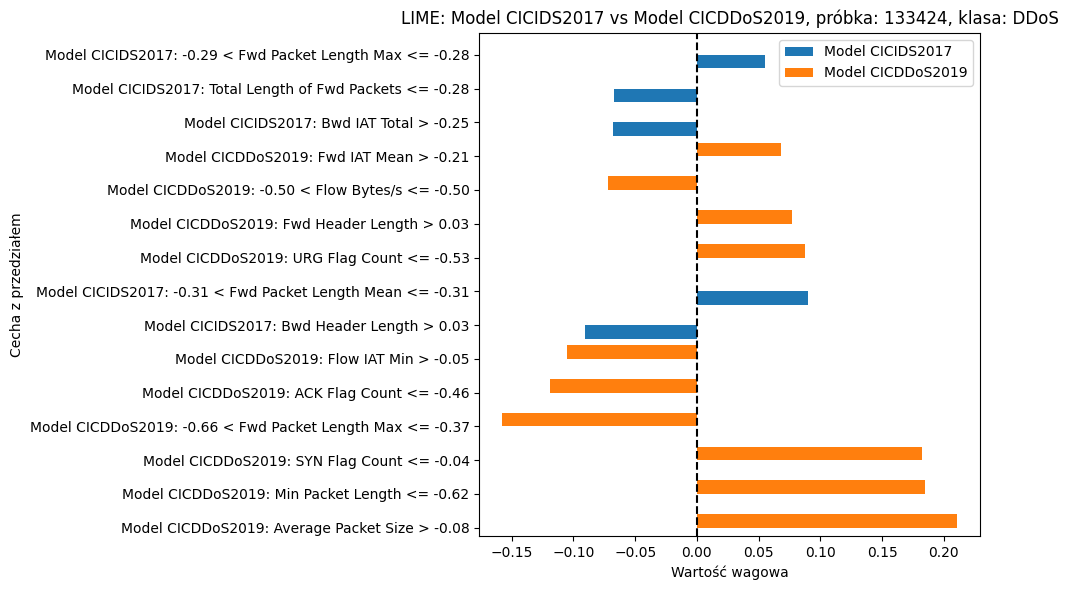

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


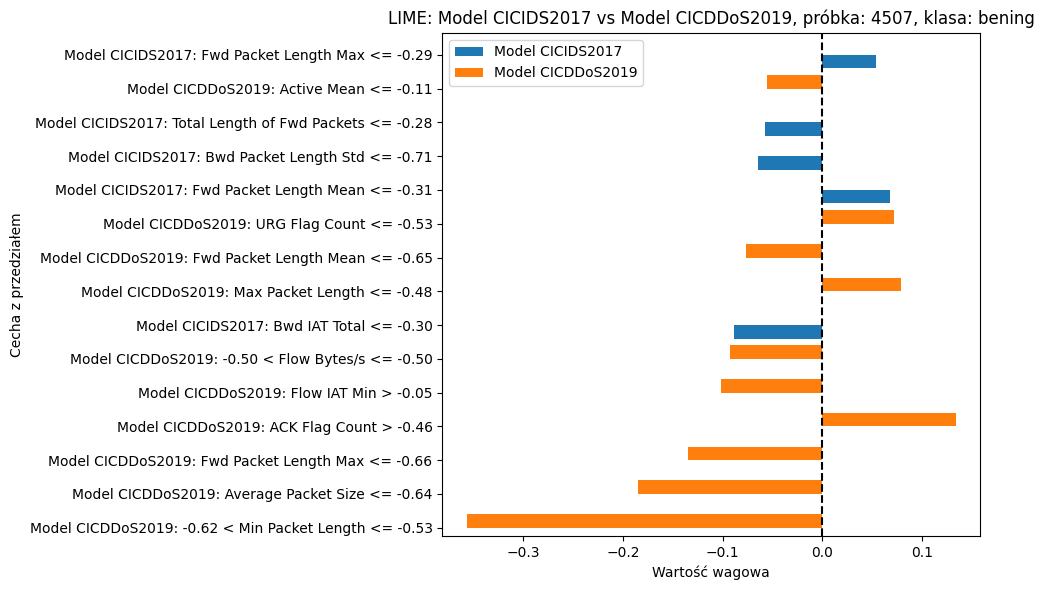

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Trening i skalowanie
def train_and_scale(df, feature_cols, label_col):
    X = df[feature_cols]
    y = df[label_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_scaled, y)
    return model, scaler, X, y

# Przykłady do analizy
def get_sample_indices(df, label_col):
    return {
        "ddos": df[df[label_col] == 1].sample(n=1, random_state=42).index.tolist(),
        "benign": df[df[label_col] == 0].sample(n=1, random_state=24).index.tolist()
    }

# Wizualizacja
def plot_lime_comparison(exp1, exp2, idx, label, model_a, model_b, save_path=None):
    df1 = pd.DataFrame(exp1.as_list(), columns=["feature", "weight_a"])
    df1["feature"] = f"{model_a}: " + df1["feature"]

    df2 = pd.DataFrame(exp2.as_list(), columns=["feature", "weight_b"])
    df2["feature"] = f"{model_b}: " + df2["feature"]

    # Połącz wszystkie cechy (nawet niepowtarzające się)
    merged = pd.merge(df1, df2, on="feature", how="outer").fillna(0)

    # Posortuj wg największego wpływu (absolutnego) i wybierz top 15
    merged['combined_abs'] = merged[['weight_a', 'weight_b']].abs().max(axis=1)
    merged = merged.sort_values(by='combined_abs', ascending=False).head(15)

    # Ustaw cechy jako indeks (oś Y)
    merged = merged.set_index("feature")

    # Wykres
    fig, ax = plt.subplots(figsize=(10, 6))
    merged['weight_a'].plot(kind='barh', ax=ax, color='tab:blue', position=1, width=0.4, label=model_a)
    merged['weight_b'].plot(kind='barh', ax=ax, color='tab:orange', position=0, width=0.4, label=model_b)

    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"LIME: {model_a} vs {model_b}, próbka: {idx}, klasa: {label}")
    plt.xlabel("Wartość wagowa")
    plt.ylabel("Cecha z przedziałem")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()




# Główna logika
df_2017 = pd.read_csv("2017.csv")
df_2019 = pd.read_csv("2019.csv")
feature_cols = df_2017.columns[:-1].tolist()
label_col = "Label"

model_2017, scaler_2017, X_2017, y_2017 = train_and_scale(df_2017, feature_cols, label_col)
model_2019, scaler_2019, X_2019, y_2019 = train_and_scale(df_2019, feature_cols, label_col)

explainer_2017 = LimeTabularExplainer(scaler_2017.transform(X_2017), feature_names=feature_cols,
                                       class_names=['Benign', 'DDoS'], discretize_continuous=True)
explainer_2019 = LimeTabularExplainer(scaler_2019.transform(X_2019), feature_names=feature_cols,
                                       class_names=['Benign', 'DDoS'], discretize_continuous=True)

# Dwa przykłady
sample_idx = get_sample_indices(df_2017, label_col)
sample_rows = df_2017.loc[sample_idx["ddos"] + sample_idx["benign"]]

for idx in sample_rows.index:
    label = sample_rows.loc[idx, label_col]
    row = sample_rows.loc[idx, feature_cols].values.reshape(1, -1)
    scaled_2017 = scaler_2017.transform(row)
    scaled_2019 = scaler_2019.transform(row)

    exp_2017 = explainer_2017.explain_instance(scaled_2017[0], model_2017.predict_proba, num_features=10)
    exp_2019 = explainer_2019.explain_instance(scaled_2019[0], model_2019.predict_proba, num_features=10)

    filename = f"lime_comparison_idx_{idx}_label_{label}.png"
    plot_lime_comparison(exp1=exp_2017, exp2=exp_2019, idx=idx, label=("bening" if label == 0 else "DDoS"), model_a="Model CICIDS2017", model_b="Model CICDDoS2019", save_path=filename)
